# Project 5: Semi-supervised image classification

### Howard Nguyen-Huu (20825782)

> assuming that only M out of N images in the traingin data have ground truth labels, design and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in the training dataset (e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).
> - Prof. Yuri Boykov

### Contributions

- single contributor: Howard Nguyen-Huu: research, design, implementation, and experiments 

## Approach and Implementation

- The proposed methodology employs a convolutional neural network (CNN) with an EfficientNet backbone for feature extraction.
- The model architecture is designed to facilitate semi-supervised learning by incorporating supervised, clustering, and consistency losses
- Clustering is performed using KMeans or Soft KMeans to group feature vectors, while consistency losses enforce invariant predictions under different data augmentations

### Dataset

- The Imagenette dataset serves as the benchmark for evaluating the model's performance
- this dataset is a subset of the larger ImageNet dataset, comprising 10 easily classified classes
- I chose it for this project due to its manageable size and diversity, making it suitable for experimentation without the computational overhead associated with the full ImageNet dataset, (since I wanted to train the models from scratch instead of using pretrained CNN weights)
- The dataset provides a balanced distribution of classes, which is essential for training robust classification models

#### Split of Labeled/Unlabeled data

- In my approach a value $p \in [0, 1]$ determines the proportion of the dataset that is labeled
  - ex. $p = 0.1$ indicates that 10% of the data is labeled, while the remaining 90% is unlabeled
  - This split is implemented in the `split_labeled_unlabeled` method of the `SemiSupervisedTrainer` class, ensuring a random and unbiased division of the dataset:

```python
def split_labeled_unlabeled(self, dataset: torch.utils.data.Dataset) -> Tuple[Subset, Subset]:
    num_samples = len(dataset)
    num_labeled = int(num_samples * self.labeled_ratio)
    indices = torch.randperm(num_samples).tolist()
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]
    return Subset(dataset, labeled_indices), Subset(dataset, unlabeled_indices)
```

- for the majority of my experiments I ran them for each of $p \in [0.1, 0.25, 0.5, 0.75]$


### Deep Learning Model

- model architecture is defined in the `SemiSupervisedClassifier` class within `representations/models/semisupclassifier.py`

#### Architecture

- I used EfficientNet CNN as the convolutional backbone, because it scored relatively well on Imagenet for the small number of parameters (i trained on a GPU with 24gb vram with a batch size of 32)

#### Feature Extraction and Classification

- The CNN backbone outputs a feature vector, which is then flattened and connected to a fully connected (Linear) layer with an output dimension of 512
- this 512-dimensional vector serves is the clustering feature, which is intended to be clustered during training
- Following the clustering feature, two additional fully connected layers with ReLU activations are used as the classifier, the output layer outputs 10 logits for each class in Imagenette
- note: the feature vectors are normalized to improve clustering performance
  - Normalization ensures that the feature space is isotropic, preventing any single feature from dominating due to scale differences
  - This was a very, very crucial step is crucial, and was found when initial experiments without normalization resulted in significantly worse clustering and classification performance
  - the normalization is implemented in the `forward` method of the `SemiSupervisedClassifier`:

```python
def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    features = self.backbone(x)
    logits = self.classifier(features)
    return F.normalize(features, dim=1), logits
```


### Loss Function

- My loss function combines multiple loss components to guide the model in learning from both labeled and unlabeled data
- found in the `SemiSupervisedLoss` class, located in `representations/losses/semisuploss.py`
- 3 loss types: supervised, clustering, and consistency losses
- The relative importance of each loss component is controlled by lambda parameters, allowing for fine-tuning based on empirical performance

#### Supervised Loss

- The supervised loss is a standard cross-entropy loss applied to labeled data, encouraging the model to correctly classify samples with known labels:

$$
\mathcal{L}_{\text{supervised}} = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$

- where:
  - $N$ is the number of labeled samples
  - $y_i$ is the true label
  - $\hat{y}_i$ is the predicted probability
- implementation:

```python
self.supervised_loss = nn.CrossEntropyLoss()
sup_loss = self.supervised_loss(logits_labeled, labels)
```

#### Clustering Loss


- The clustering loss aims to group feature vectors of unlabeled data into clusters that correspond to the underlying classes
- this was intended to force the network to learn of meaningful representations even without explicit labels
- I used both:
  - **KMeans Clustering:** Assigns each feature vector to the nearest centroid, providing hard assignments.
  - **Soft KMeans Clustering:** Offers soft assignments, allowing feature vectors to partially belong to multiple clusters.

- The clustering loss is defined as a cross-entropy loss between the model's logits for unlabeled data and their cluster assignments:

$$
\mathcal{L}_{\text{clustering}} = \frac{1}{M} \sum_{j=1}^{M} \text{CE}(\hat{y}_j, c_j)
$$

- where:
  - $M$ is the number of unlabeled samples
  - $\hat{y}_j$ are the logits
  - $c_j$ are the cluster assignments.

- Clustering assignments are updated using the `update_clusters` method of the `cluster_assigner` object, which can be either `KMeansClusterAssignment` or `SoftKMeansClusterAssignment` both in `representations/losses/kmeans.py`

- The clustering loss computation is as follows:

```python
self.cluster_assigner = (
    SoftKMeansClusterAssignment(num_classes, feature_dim)
    if soft_kmeans
    else KMeansClusterAssignment(num_classes, feature_dim)
)
cluster_assignments = self.cluster_assigner.update_clusters(all_features)
cluster_loss = F.cross_entropy(logits_unlabeled[:min_batch_size], cluster_assignments[:min_batch_size])
```

- i experimented with a cosine ramp-up schedule to gradually increases the weight of the clustering loss over the initial epochs to ensure stable training:

$$
\text{scale} = \frac{1 - \cos\left(\frac{\pi \times \text{epoch}}{\text{cluster\_rampup\_epochs}}\right)}{2}
$$

#### Consistency Loss(es)

- Augmentation Consistency, classifier logits from the same unlabeled samples weak and strong image augmentations softmaxed to get a probability which is then compared to each other using KL divergence
- Intuition: we can still make the network learn that it should have similar classifications for the same unlabeled images regardless of the augmentations
- Clustering Consistency, uses the same approach and method but with the classifier output logits and the distances from the nearest centroid

##### Augmentation Consistency

- I used augmentation consistency loss to make the model's predictions remain consistent under different augmentations of the same unlabeled image
- This enhances the model's robustness to variations in input data. The loss is computed as the symmetric Kullback-Leibler (KL) divergence between the softmax outputs of weakly and strongly augmented views:

$$
\mathcal{L}_{\text{aug\_consistency}} = \frac{1}{2} \left( \text{KL}(P_{\text{weak}} \| P_{\text{strong}}) + \text{KL}(P_{\text{strong}} \| P_{\text{weak}}) \right)
$$

- where:
  - $P_{\text{weak}}$ and $P_{\text{strong}}$ are the probability distributions obtained from weak and strong augmentations, respectively

- the augmentations used can be found in the initialization of `representations/datasets/imagenette.py` as `self.weak_augmentations` and `self.strong_augmentations` (using `torchvision` builtin augmentations) including:
  - ColorJitter
  - RandomAutocontrast
  - RandomEqualize
  - RandomPosterize
  - RandomSolarize
  - RandomErasing

- my implementation also uses temperature scaling to smooth the probability distributions before computing KL divergence:

```python
def consistency_loss(self, logits1, logits2):
    probs1 = F.softmax(logits1 / self.temperature, dim=-1)
    probs2 = F.softmax(logits2 / self.temperature, dim=-1)
    return 0.5 * (
        F.kl_div(probs1.log(), probs2, reduction="batchmean")
        + F.kl_div(probs2.log(), probs1, reduction="batchmean")
    )
aug_consistency_loss = self.consistency_loss(logits_aug1, logits_aug2)
```

##### Clustering Consistency

- Clustering consistency loss aligns the model's predictions with the cluster assignments derived from feature vectors
- This ensures that the classifier's logits correspond to the semantic groupings identified during clustering
- The loss is calculated as the average cross-entropy loss between the predicted logits and the nearest cluster assignments for both labeled and unlabeled data:

$$
\mathcal{L}_{\text{cluster\_consistency}} = \frac{1}{2} \left( \text{CrossEntropy}(\text{logits}_\text{unlabeled}, \text{cluster\_assignments}_\text{unlabeled}) + \text{CrossEntropy}(\text{logits}_\text{labeled}, \text{cluster\_assignments}_\text{labeled}) \right)
$$

- The implementation involves computing the logits corresponding to cluster assignments and applying cross-entropy loss:

```python
unlabeled_cluster_logits = self.cluster_assigner.compute_logits(features_unlabeled)
labeled_cluster_logits = self.cluster_assigner.compute_logits(features_labeled)
cluster_consistency_loss = 0.5 * (
    F.cross_entropy(logits_unlabeled, unlabeled_cluster_logits.argmax(dim=1)) +
    F.cross_entropy(logits_labeled, labeled_cluster_logits.argmax(dim=1))
)
```

#### Loss Calculations

- The total loss is a weighted sum of all individual loss components, controlled by lambda parameters:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{supervised}} + \lambda_{\text{cluster}} \times \mathcal{L}_{\text{clustering}} + \lambda_{\text{aug\_consistency}} \times \mathcal{L}_{\text{aug\_consistency}} + \lambda_{\text{cluster\_consistency}} \times \mathcal{L}_{\text{cluster\_consistency}}
$$

- The lambda parameters determine the relative importance of each loss component and are tuned based on empirical performance

### Training loop


- for each labeled batch:
  - sample an unlabeled batch, (looping back to the first batch if it runs out
  - apply strong augmentations to the labeled data, apply both weak and strong augmentations to the unlabeled data
  - get features and classification logits for labeled data and both weakly and stronly augmented unlabeled data
  - compute combined loss is (supervised, clustering, and consistency losses based on lambdas)

### Validation

- i seperated a validation set which has not been seen at all in the training data to validate
- this ensures an unbiased assessment of the model's capabilities
- instead of overall accuracy, I used per-class mean accuracy
  - in early testing the model accuracy looked higher even when the model did not perform well, due to class imbalances
  - this is a better representation of how the model performs across all classes


## Reproduction of results

- results can be modified using the below code blocks (after downloading and extracting imagenette):
- however it is recommended to just use the training script found in `scripts/run.py`

In [2]:
from representations.datasets.imagenette import ImagenetteDataModule
from representations.trainers.trainer import SemiSupervisedTrainer

from pathlib import Path

In [3]:
data = ImagenetteDataModule(Path("/home/howard/representations/data/imagenette2-320/"))

feature_dim = 512
loss_args = {
    "lambda_cluster": 1.0,
    "cluster_all": True,
    "lambda_aug_consistency": 1.0,
    "lambda_cluster_consistency": 0.0,
    "soft_kmeans": True
}
labeled_ratio = 0.5 # fraction of dataset that is labeled

trainer = SemiSupervisedTrainer(num_classes=10, labeled_ratio=0.5, pretrained=False, loss_args=loss_args)
_ = trainer.train(data, num_epochs=1)

## Experiments and Results

- 4 experiments were done, all with the datasets at 10, 25, 50, and 75% labeled:

1. Basic k-means clustering (supervised + clustering + augmentation consistency)
   - Baseline semi-supervised setup using hard k-means.  
   - Evaluates how well basic clustering plus augmentation consistency can improve performance over supervised loss alone.

2. Soft k-means clustering (supervised + clustering + augmentation consistency + clustering consistency)
   - Tests soft cluster assignments, which might better capture uncertainty than hard assignments.  
   - Adds clustering consistency to align classifier logits with cluster predictions more tightly.

3. Soft k-means clustering (supervised + clustering + augmentation consistency; no clustering consistency)
   - Compares directly against Experiment 2 to isolate the effect of clustering consistency
   - It may not be useful as the clustering loss should achieve a similar effect already

4. Ablation (supervised only)
   - Serves as a purely supervised baseline (no clustering, no consistency).  
   - Gauges the net benefit of adding semi-supervised components by comparing to the simplest approach.

### 1. Basic K-Means
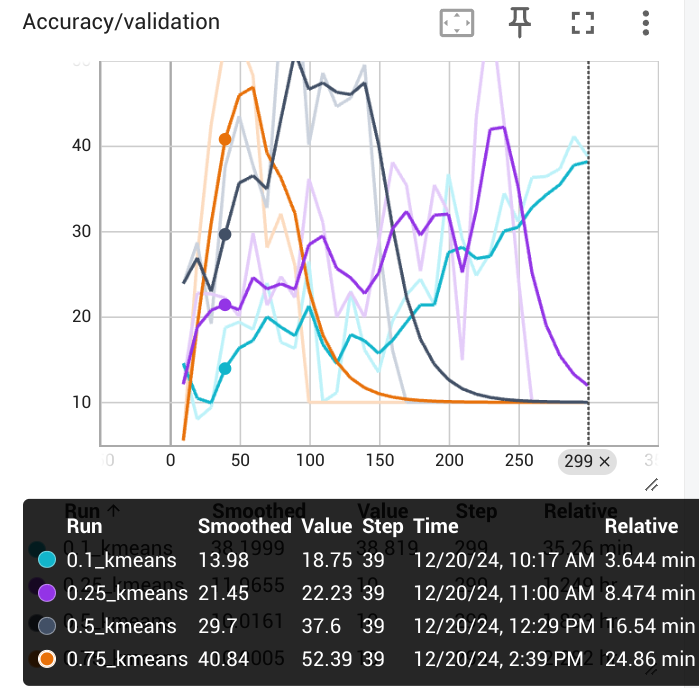
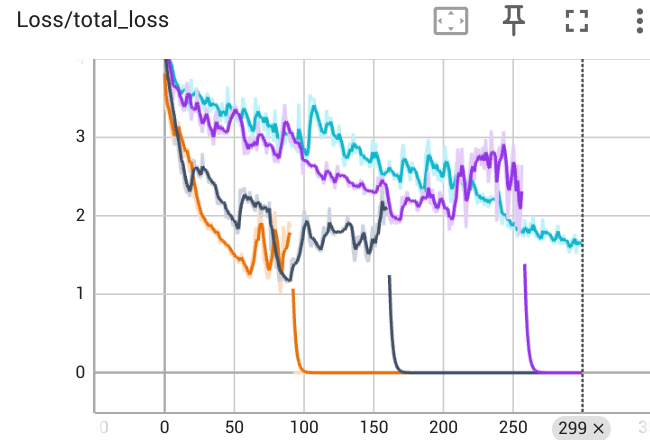


### 2. Soft K-Means with all losses

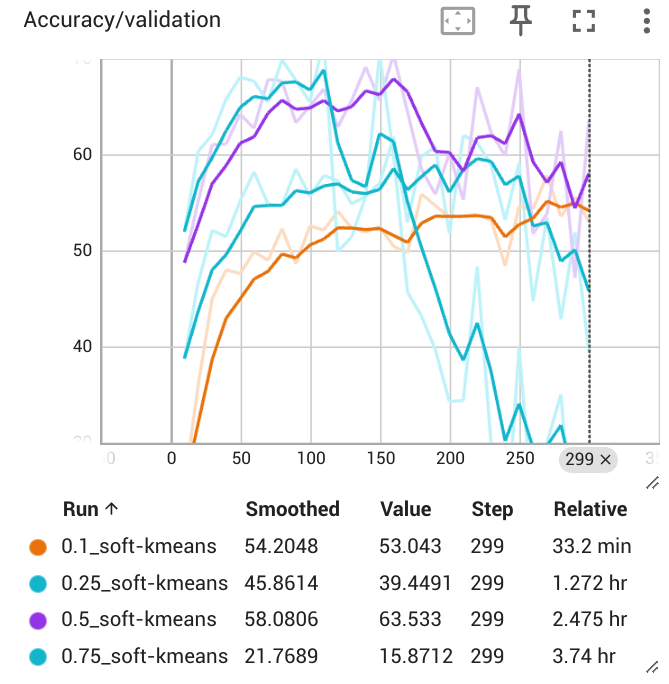
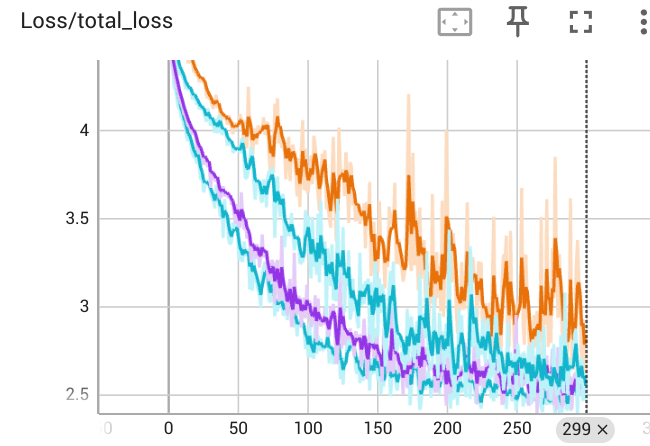
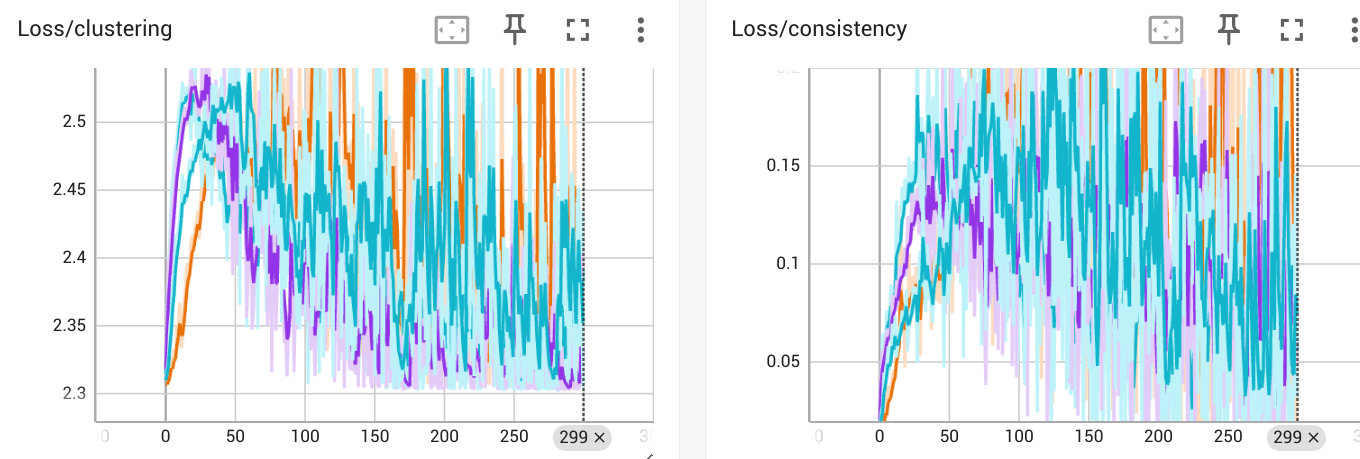
- 

### 3. Soft K-Means without k-means consistency loss

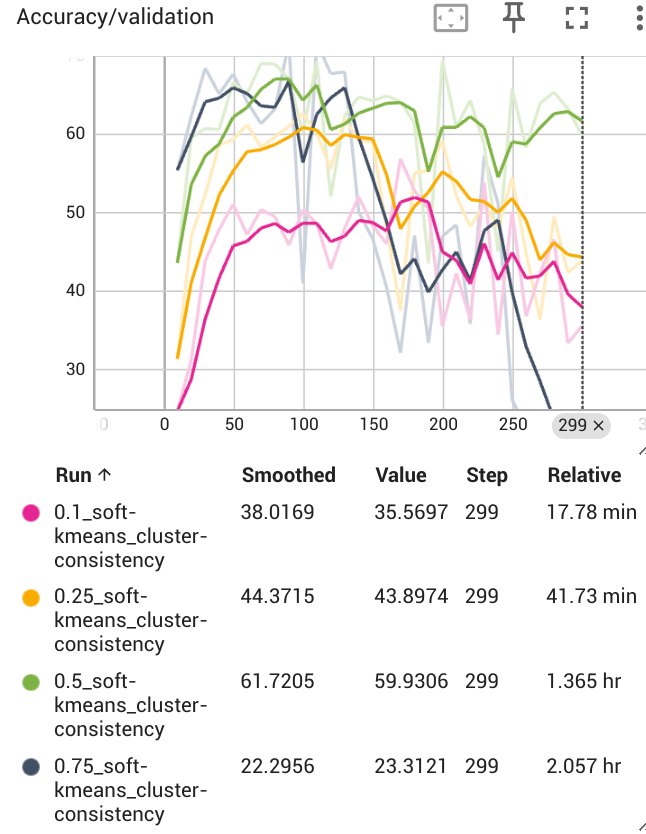
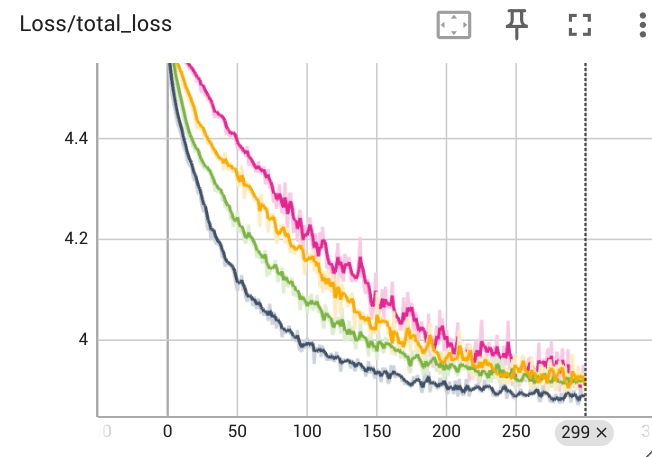


### 4. Supervised Only

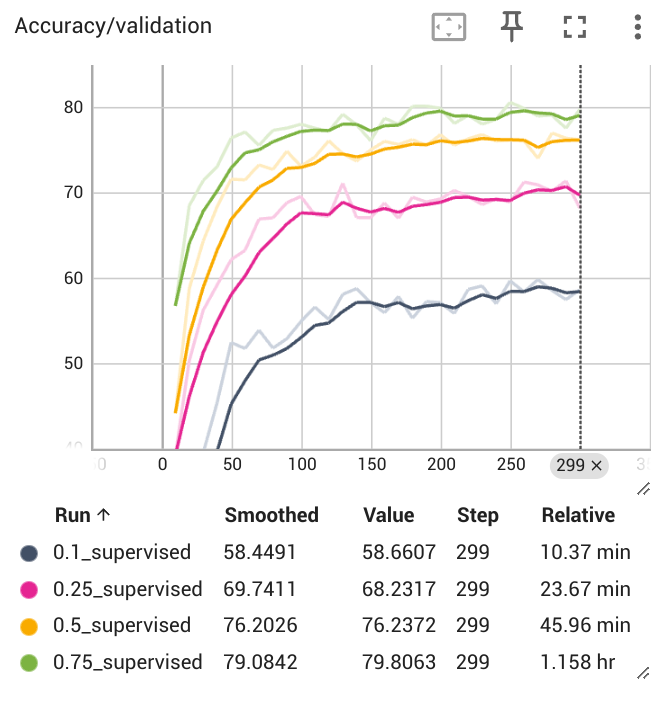 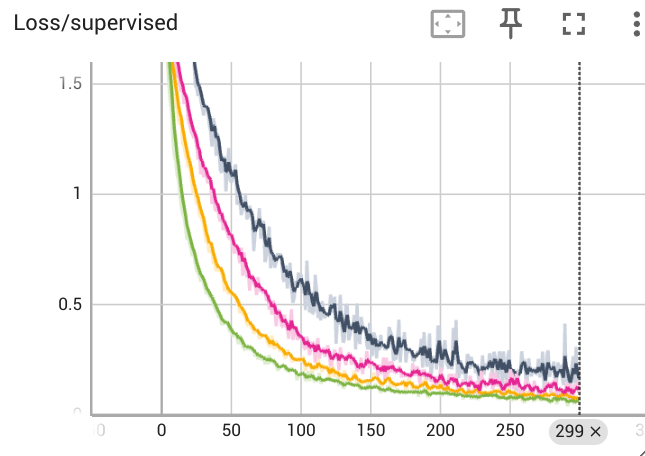

- 

## Analysis and Conclusions
1. Basic k-means clustering (supervised + clustering + augmentation consistency)
   - Highly unstable training, likely due to the non-differentiable nature of hard cluster assignments (k-means) directly in the loss
   - This instability often pushes the model into extreme parameter states, producing NaNs gradients
   - Without a smooth gradient pathway, the model struggles to refine its representations, leading to erratic loss behavior

2. Soft k-means clustering (supervised + clustering + augmentation consistency + clustering consistency)
   - Training exhibits extremely high variation in clustering loss, making the optimization process difficult
   - The clustering consistency loss unexpectedly increases over time, suggesting the model fails to align its predicted clusters with the learned representations
   - Interestingly, performance improves as the labeled fraction decreases, implying the model’s semi-supervised component benefits when forced to rely more on unlabeled structure
   - Soft assignments help but the added clustering consistency loss may overconstrain the model, causing difficulty in settling into a stable solution.  
   - Possible improvements: i could tune or reduce the weight of clustering consistency, use alternative scheduling strategies, or improve regularization methods (e.g., temperature scaling, dynamic weighting) to stabilize the relationship between clusters and predictions.

3. Soft k-means clustering (supervised + clustering + augmentation consistency; no clustering consistency)  
   - Still experiences very high clustering loss variation but removing the clustering consistency term reduces some training instability
   - Similarly to the previous experiment, fewer labels (more unlabeled data reliance) appear to improve validation performance the model
   - Possible improvements:  adjusting the clustering method (e.g., different initialization, centroid update frequency), adopt better feature normalization, or apply more robust data augmentations to improve cluster quality

5. Ablation (supervised only):
   - Pure supervised training provides the best accuracy and stable convergence, with low variance across runs.  
   - even without semi-supervised components, the simplicity yields consistent, interpretable results
   - the validation performance improves as the number of labels increase  
   - without complex unsupervised constraints, the model trains on a well-defined loss, ensuring stable and predictable optimization  

- Overall Conclusions:
- Complex semi-supervised methods often introduce significant optimization challenges, as evidenced by instability and increasing losses
- Hard clustering (k-means) is too rigid, leading to non-differentiable steps that destabilize training. Soft clustering helps, but still requires careful balancing of consistency terms 
- When label availability is low, semi-supervised approaches show promise—if properly regularized
- Future work should focus on smoother clustering methods, dynamic weighting of loss components, and more robust initialization and augmentation strategies to achieve stable and meaningful improvements over the pure supervised baseline